In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2022-01-25 00:40:22.396488: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-01-25 00:40:22.396520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", test_set_path = "test_set", validation_set_path = "validation_set", channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = 200, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = 201, sample_end = 250, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = 251, sample_end = 300, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel):
    png_path = "data/" + class_name + "/dat_ch" + str(channel) + "_" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 4)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    for i in range(4):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(4, 4)
    fig.set_figwidth(10)
    fig.set_figheight(12)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(4):
        for col in range(4):
            class_name = "A" + str(row + 1) + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], channels), dtype="uint8")
    for ch in range(channels):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(4):
            for col in range(4):
                class_name = "A" + str(row + 1) + str(col + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "data_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)

def create_labeled_data(srs_path = "tensors", label_type = "categorical"):
    labeled_data = []
    categories = os.listdir(srs_path)
    categories.sort()
    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = A11, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    Y = np.array(Y)
    np.reshape(Y, (len(Y), 1))

    if label_type == "regression":
        Y = to_regression(Y)
    else:
        Y = to_categorical(Y)

    return X, Y

def to_regression(category_index, max_row = 4, max_col = 4):
    col = category_index % max_col
    row = (category_index - col) // max_row
    x_pos = (1.0/max_col) * (col + 1) - (0.5/max_col)
    y_pos = (1.0/max_row) * (row + 1) - (0.5/max_row)
    tensor = np.array(list(map(lambda x, y:[x,y], x_pos, y_pos)))
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def train_model(model, model_file_name = "model.h5", target_accuracy = 0.90):
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    current_accuracy = 0
    while (current_accuracy < target_accuracy):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=10, validation_data=(test_X, test_Y), verbose=1, callbacks=[monitor])
        _, validation_accuracy = model.evaluate(val_X, val_Y, verbose=1)
        if (current_accuracy < validation_accuracy):
            print("Validation accuracy > {:.2f}".format(validation_accuracy * 100.0))
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_accuracy = validation_accuracy
        else:
            if os.path.exists(model_file_name):
                model = load_model(model_file_name)

    print("Done!")

In [3]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def CNN_categorical(input_shape = (32, 32, 4), output_categories = 16):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_categories, activation='softmax'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
zip_data_path = "data.zip"
train_set_path = "train_set"
test_set_path = "test_set"
validation_set_path = "validation_set"

crop_area = (0, 8, 32, 24)
size = (16, 8)

channel_sensors = 4

generate_datasets (zip_data_path, train_set_path, test_set_path, validation_set_path, channels = channel_sensors, crop_area = crop_area, size = size)

In [10]:
model_type = "regression" # set "regression" or "categorical"

train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type)


In [11]:
if model_type == "regression":
    model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
else:
    model = CNN_categorical(input_shape = (size[1], size[0], channel_sensors), output_categories = 16)

In [12]:
model_file_name = "model_16x16.h5" # Set the file name for the model
target_accuracy = 0.99

train_model(model, model_file_name, target_accuracy)

Epoch 1/100
320/320 [==============================] - 2s 6ms/step - loss: 0.7007 - accuracy: 0.7403 - val_loss: 0.5754 - val_accuracy: 0.9438
Epoch 2/100
320/320 [==============================] - 2s 6ms/step - loss: 0.5840 - accuracy: 0.7947 - val_loss: 0.5315 - val_accuracy: 0.9175
Epoch 3/100
320/320 [==============================] - 3s 9ms/step - loss: 0.5519 - accuracy: 0.8381 - val_loss: 0.5281 - val_accuracy: 0.8838
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5413 - accuracy: 0.8584 - val_loss: 0.5285 - val_accuracy: 0.9200
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5352 - accuracy: 0.8584 - val_loss: 0.5268 - val_accuracy: 0.8963
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5325 - accuracy: 0.8716 - val_loss: 0.5289 - val_accuracy: 0.9100
Epoch 7/100
320/320 [==============================] - 2s 6ms/step - loss: 0.5307 - accuracy: 0.8625 - val_loss: 0.5265 - val_accuracy: 0.9187

In [13]:
file = validation_set_path + "/A12/data_251.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

Input sample = validation_set/A12/data_251.npy, model prediction = [[0.33641922 0.14660469]]


In [ ]:
model = load_model(model_file_name)

model.summary()

tf.keras.utils.plot_model(model, filename + "/" + filename + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # or tf.uint8
converter.inference_output_type = tf.float32  # or tf.uint8
tflite_model = converter.convert()

# Save the model.
with open(filename + "/" + filename + '.tflite', 'wb') as f:
  f.write(tflite_model)

print("Done!")

Grid (sample = 280, channels = 4)


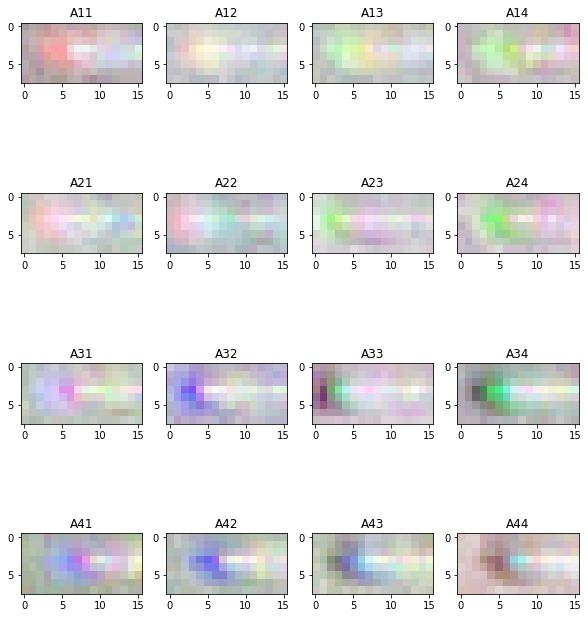

In [14]:
show_grid(sample = 280, crop_area = crop_area, size = size)

Sample = 280, class = A21


/tmp/ipykernel_18427/2128122446.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


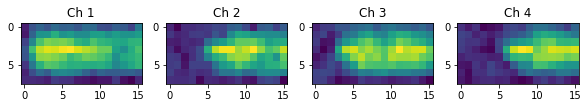

In [15]:
show_sample(class_name = "A21", sample = 280, crop_area = crop_area, size = size)